# Descriptive analytics

# Temporal Demand Patterns & Seasonality # Lina
- Pro Tag / Pro Woche / Pro Monat / Pro Jahr 
- Mit Wetterdaten vergleichen
 

## Geographical Demand Patterns # Nico, Jieyu
## ? Pro Stadtteil angemeldete Autos
## Altersgruppen je Stadtteil -> Zusammenhang zu Abo Modellen
## Pass -> Häufig für den Arbeitsweg? (RoundTrip, OneWay, Zeiten)

## KPIs
- Aktuelle Auslastung (Live & Historisch, Pro Station) (-> Mehr Stationen, Fahrräder?) # Lukas 
- Ausfall/Probleme: (Wartungsaufwand (z.B. in Prozent available/not available), ) # Ange
- Umsatz durch "Minutengeld" # Marc
- Anteil an Arten von Passhaltern?
- Anteil von Tripcategories?


In [145]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as pp
import matplotlib.image as img
from matplotlib.gridspec import GridSpec
from six.moves import urllib
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

import glob

from IPython import display
from IPython.display import Image
Image("Datasets/Map_Philadelphia_20210713")

%matplotlib inline

## preparing & cleaning data



In [2]:
csv_files = glob.glob('Datasets/RideIndego 2016/*.csv')
df = pd.concat([pd.read_csv(f) for f  in csv_files], ignore_index = True)

### Find out NaN Values

In [3]:
df.isna().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_station_id         10
start_lat                17
start_lon                17
end_station_id            0
end_lat                1591
end_lon                1591
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
dtype: int64

### Drop any Row with NaN 0 in end_lat end_lon



In [4]:
df['start_lat'] = pd.to_numeric(df['start_lat'], errors='coerce')
df['start_lon'] = pd.to_numeric(df['start_lon'], errors='coerce')
df['start_station_id'] = pd.to_numeric(df['start_station_id'], errors='coerce')
df['end_station_id'] = pd.to_numeric(df['end_station_id'], errors='coerce')
df['end_lat'] = pd.to_numeric(df['end_lat'], errors='coerce')
df['end_lon'] = pd.to_numeric(df['end_lon'], errors='coerce')
df['bike_id'] = pd.to_numeric(df['bike_id'], errors='coerce')
df['plan_duration'] = pd.to_numeric(df['plan_duration'], errors='coerce')

In [5]:
df.isna().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_station_id         10
start_lat                69
start_lon                69
end_station_id            0
end_lat                3023
end_lon                3023
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
dtype: int64

In [6]:
df = df.dropna(how='any').reset_index(drop=True)
df

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,4516691,600,1/1/2016 0:04,1/1/2016 0:14,3046.0,39.950120,-75.144720,3041,39.968490,-75.135460,3564,30,One Way,Indego30
1,4516692,1320,1/1/2016 0:07,1/1/2016 0:29,3028.0,39.940610,-75.149580,3019,39.954030,-75.149830,2629,30,One Way,Indego30
2,4516693,780,1/1/2016 0:14,1/1/2016 0:27,3007.0,39.945170,-75.159930,3066,39.945610,-75.173480,3430,30,One Way,Indego30
3,4516694,1320,1/1/2016 0:20,1/1/2016 0:42,3005.0,39.947330,-75.144030,3064,39.938400,-75.173270,3351,0,One Way,Walk-up
4,4516695,600,1/1/2016 0:20,1/1/2016 0:30,3045.0,39.947920,-75.162370,3028,39.940610,-75.149580,3715,30,One Way,Indego30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651966,55223960,660,9/30/2016 23:51,10/1/2016 0:02,3023.0,39.950481,-75.172859,3114,39.937752,-75.180122,6725,30,One Way,Indego30
651967,55223958,900,9/30/2016 23:53,10/1/2016 0:08,3032.0,39.945271,-75.179710,3011,39.960461,-75.197006,11031,30,One Way,Indego30
651968,55223957,540,9/30/2016 23:55,10/1/2016 0:04,3007.0,39.945171,-75.159927,3025,39.937241,-75.161201,2706,30,One Way,Indego30
651969,55223956,480,9/30/2016 23:56,10/1/2016 0:04,3007.0,39.945171,-75.159927,3025,39.937241,-75.161201,2497,30,One Way,Indego30


### Further Inspectation of data to prepare descriptive analysis (Marc)


In [7]:
df.describe()

,trip_id,duration,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration
count,6.519710e+05,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000
mean,3.510074e+07,1304.646955,3047.424994,39.952599,-75.168769,3046.760276,39.846196,-74.968480,4017.813906,29.610144
std,2.720246e+07,3656.709547,31.559946,0.070884,0.132684,31.432813,2.056511,3.869193,1735.005923,40.916349
min,4.516691e+06,60.000000,3000.000000,0.000000,-75.223991,3000.000000,0.000000,-75.223991,2472.000000,0.000000
25%,4.725896e+06,480.000000,3023.000000,39.945610,-75.179710,3022.000000,39.945271,-75.179390,3280.000000,30.000000
50%,3.870654e+07,720.000000,3043.000000,39.951120,-75.167351,3041.000000,39.950710,-75.167107,3536.000000,30.000000
75%,5.701548e+07,1200.000000,3063.000000,39.959229,-75.158127,3063.000000,39.957081,-75.156952,5190.000000,30.000000
max,8.758284e+07,86400.000000,3129.000000,39.991791,0.000000,3129.000000,39.991791,0.000000,55195.000000,365.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651971 entries, 0 to 651970
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              651971 non-null  int64  
 1   duration             651971 non-null  int64  
 2   start_time           651971 non-null  object 
 3   end_time             651971 non-null  object 
 4   start_station_id     651971 non-null  float64
 5   start_lat            651971 non-null  float64
 6   start_lon            651971 non-null  float64
 7   end_station_id       651971 non-null  int64  
 8   end_lat              651971 non-null  float64
 9   end_lon              651971 non-null  float64
 10  bike_id              651971 non-null  int64  
 11  plan_duration        651971 non-null  int64  
 12  trip_route_category  651971 non-null  object 
 13  passholder_type      651971 non-null  object 
dtypes: float64(5), int64(5), object(4)
memory usage: 69.6+ MB


Converting the dtype of station_id to integer

In [9]:
df['start_station_id'] = df['start_station_id'].astype('int64')
df['end_station_id'] = df['end_station_id'].astype('int64')

Alteration of start_time and end_time to datetime type

In [10]:
df['start_time'] = pd.to_datetime(df['start_time'])

In [11]:
df['end_time'] = pd.to_datetime(df['end_time'])

Calculate the length of a trip

In [12]:
df["duration_trip"] = df["end_time"] - df["start_time"]

Now I am breaking the datetime of start_time into smaller parts(days, time, hour) to make it possible to visualize the usage over different periods. I am taking the start_time, not the end_time since it shows the demand.

In [13]:
df['date'] = df['start_time'].dt.strftime('%m-%d')
#here something is not working correctly yet, has to be further examined

In [14]:
df["time"] = df["start_time"].apply(lambda dt: dt.time)

In [15]:
df["hour"] = df["start_time"].apply(lambda dt: dt.hour)

In [16]:
df["weekday"] = df["start_time"].apply(lambda dt: dt.dayofweek)

In [17]:
df["month"] = df["start_time"].apply(lambda dt: dt.month)

In [18]:
df["full_date"] = [d.date() for d in df["start_time"]]


In [19]:
df['date_hour'] = df['start_time'].dt.strftime('%m-%d-%H')


In [20]:
#for a later purpose we will convert the duration from seconds to minutes, dividing it by 60:
df["duration"] = df["duration"] / 60

Inspection of new dataframe, uncomment if necessary

In [21]:
df.head()

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,...,trip_route_category,passholder_type,duration_trip,date,time,hour,weekday,month,full_date,date_hour
0,4516691,10.0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,39.95012,-75.14472,3041,39.96849,-75.13546,...,One Way,Indego30,0 days 00:10:00,01-01,<built-in method time of Timestamp object at 0...,0,4,1,2016-01-01,01-01-00
1,4516692,22.0,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,39.94061,-75.14958,3019,39.95403,-75.14983,...,One Way,Indego30,0 days 00:22:00,01-01,<built-in method time of Timestamp object at 0...,0,4,1,2016-01-01,01-01-00
2,4516693,13.0,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,39.94517,-75.15993,3066,39.94561,-75.17348,...,One Way,Indego30,0 days 00:13:00,01-01,<built-in method time of Timestamp object at 0...,0,4,1,2016-01-01,01-01-00
3,4516694,22.0,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,39.94733,-75.14403,3064,39.93840,-75.17327,...,One Way,Walk-up,0 days 00:22:00,01-01,<built-in method time of Timestamp object at 0...,0,4,1,2016-01-01,01-01-00
4,4516695,10.0,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,39.94792,-75.16237,3028,39.94061,-75.14958,...,One Way,Indego30,0 days 00:10:00,01-01,<built-in method time of Timestamp object at 0...,0,4,1,2016-01-01,01-01-00


In [22]:
df.describe()

,trip_id,duration,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,duration_trip,hour,weekday,month
count,6.519710e+05,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971.000000,651971,651971.000000,651971.000000,651971.000000
mean,3.510074e+07,21.744116,3047.424994,39.952599,-75.168769,3046.760276,39.846196,-74.968480,4017.813906,29.610144,0 days 00:22:29.216606260,13.867882,2.849348,7.364406
std,2.720246e+07,60.945159,31.559946,0.070884,0.132684,31.432813,2.056511,3.869193,1735.005923,40.916349,0 days 01:33:32.666900885,5.023578,1.925705,2.844950
min,4.516691e+06,1.000000,3000.000000,0.000000,-75.223991,3000.000000,0.000000,-75.223991,2472.000000,0.000000,-1 days +23:04:00,0.000000,0.000000,1.000000
25%,4.725896e+06,8.000000,3023.000000,39.945610,-75.179710,3022.000000,39.945271,-75.179390,3280.000000,30.000000,0 days 00:08:00,10.000000,1.000000,5.000000
50%,3.870654e+07,12.000000,3043.000000,39.951120,-75.167351,3041.000000,39.950710,-75.167107,3536.000000,30.000000,0 days 00:12:00,15.000000,3.000000,8.000000
75%,5.701548e+07,20.000000,3063.000000,39.959229,-75.158127,3063.000000,39.957081,-75.156952,5190.000000,30.000000,0 days 00:20:00,18.000000,4.000000,10.000000
max,8.758284e+07,1440.000000,3129.000000,39.991791,0.000000,3129.000000,39.991791,0.000000,55195.000000,365.000000,19 days 00:59:00,23.000000,6.000000,12.000000


In [23]:
len(df.date_hour.unique())

8535

### Including the weather data 

In [24]:
#import weather data
#STR_Nov = pd.read_csv("Car2Go_STR_SampleData.csv", encoding = "ISO-8859-1")
weather = pd.read_csv('weather_hourly_philadelphia.csv')

In [25]:
weather.head()

,date_time,max_temp,min_temp,precip
0,2015-01-02 01:00:00,3.3,3.3,0.0
1,2015-01-02 02:00:00,2.8,2.8,0.0
2,2015-01-02 03:00:00,2.2,2.2,0.0
3,2015-01-02 04:00:00,0.6,0.6,0.0
4,2015-01-02 05:00:00,1.1,1.1,0.0


In [26]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  43785 non-null  object 
 1   max_temp   43785 non-null  float64
 2   min_temp   43785 non-null  float64
 3   precip     43785 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.3+ MB


In [27]:
weather['date_time'] = pd.to_datetime(weather['date_time'])
weather['date'] = weather['date_time'].dt.strftime('%m-%d')
weather['hour'] = weather["date_time"].apply(lambda dt: dt.hour)

In [28]:
weather['date_hour'] = weather['date_time'].dt.strftime('%m-%d-%H')
weather['year'] = pd.DatetimeIndex(weather['date_time']).year
weather = weather[weather['year'] == 2016]

#pd. DatetimeIndex(df['date']). year.
weather.head()

,date_time,max_temp,min_temp,precip,date,hour,date_hour,year
8736,2016-01-01 01:00:00,7.2,7.2,0.0,01-01,1.0,01-01-01,2016.0
8737,2016-01-01 02:00:00,6.7,6.7,0.0,01-01,2.0,01-01-02,2016.0
8738,2016-01-01 03:00:00,6.7,6.7,0.0,01-01,3.0,01-01-03,2016.0
8739,2016-01-01 04:00:00,6.1,6.1,0.0,01-01,4.0,01-01-04,2016.0
8740,2016-01-01 05:00:00,6.1,6.1,0.0,01-01,5.0,01-01-05,2016.0


Combine both dataframes into one using mapping:

In [29]:
# have to use something else than a full merge as it duplicates everything from df
df_weather = pd.merge(df, weather, on="date_hour", how="left") 

In [30]:
# let us take another look at the merged dataframe:
df_weather.head()


,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,...,month,full_date,date_hour,date_time,max_temp,min_temp,precip,date_y,hour_y,year
0,4516691,10.0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,39.95012,-75.14472,3041,39.96849,-75.13546,...,1,2016-01-01,01-01-00,2016-01-01,6.7,6.7,0.0,01-01,0.0,2016.0
1,4516692,22.0,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,39.94061,-75.14958,3019,39.95403,-75.14983,...,1,2016-01-01,01-01-00,2016-01-01,6.7,6.7,0.0,01-01,0.0,2016.0
2,4516693,13.0,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,39.94517,-75.15993,3066,39.94561,-75.17348,...,1,2016-01-01,01-01-00,2016-01-01,6.7,6.7,0.0,01-01,0.0,2016.0
3,4516694,22.0,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,39.94733,-75.14403,3064,39.93840,-75.17327,...,1,2016-01-01,01-01-00,2016-01-01,6.7,6.7,0.0,01-01,0.0,2016.0
4,4516695,10.0,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,39.94792,-75.16237,3028,39.94061,-75.14958,...,1,2016-01-01,01-01-00,2016-01-01,6.7,6.7,0.0,01-01,0.0,2016.0


# Task 2: Descriptive analytics

### a) Temporal Demand Patterns and Seasonality (Lina, Marc)

In [31]:
#calculate the demand per hour
#hourly_demand = df.groupby(["hour"]).agg(demand=("bike_id", 'count'))
#hourly_demand = pd.DataFrame(hourly_demand)
#hourly_demand
hourly_demand = df.groupby(["date","hour"])["trip_id"].nunique()
hourly_demand = pd.DataFrame(hourly_demand)
hourly_demand


trip_id
date  hour         
01-01 0          26
      1          40
      2          33
      3           6
      4           1
...             ...
12-31 19         28
      20         29
      21         18
      22         21
      23         12

[8535 rows x 1 columns]

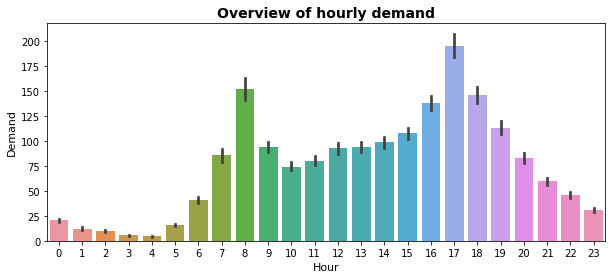

In [32]:
fig, ax = pp.subplots(figsize=(10,4))

sns.barplot(x=hourly_demand.index.get_level_values(1), y=hourly_demand["trip_id"],ax=ax)
pp.xlabel('Hour', fontdict={'size':11})
pp.ylabel("Demand", fontdict={"size":11})
pp.title("Overview of hourly demand", fontsize=14.0, fontweight='bold')

pp.show()

In [33]:
#demand per weekday:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
#daily_demand = df.groupby(["weekday"]).agg(demand=("bike_id", 'count'))
daily_demand = df.groupby(["month","weekday"])["trip_id"].nunique()
daily_demand = pd.DataFrame(daily_demand)
daily_demand

trip_id
month weekday         
1     0           1836
      1           2023
      2           2538
      3           3083
      4           3790
...                ...
12    2           5366
      3           6780
      4           6164
      5           3453
      6           2860

[84 rows x 1 columns]

In [34]:
daily_demand.columns.values

array(['trip_id'], dtype=object)

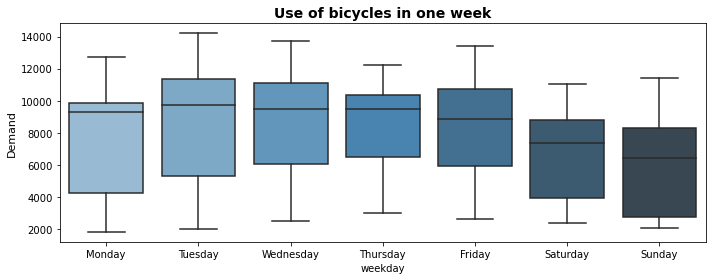

In [35]:
fig, ax = pp.subplots(figsize=(10,4))

sns.boxplot(x=daily_demand.index.get_level_values(1),y=daily_demand["trip_id"],palette = 'Blues_d')

pp.ylabel("Demand", fontsize=11)
pp.title("Use of bicycles in one week", fontsize=14, fontweight="bold", color="k")
pp.tight_layout()
pp.gca().set_xticklabels(\
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);

pp.show()

In [36]:
#calculate the monthly demand:
# different approach:
#monthly_demand = df.groupby(["month"]).agg(demand=("bike_id", 'count'))
monthly_demand = df.groupby(["month"])["trip_id"].nunique()

monthly_demand = pd.DataFrame(monthly_demand)
monthly_demand

,trip_id
month,
1,17773
2,19284
3,36102
4,42324
5,55922
6,72578
7,76215
8,77673
9,79578


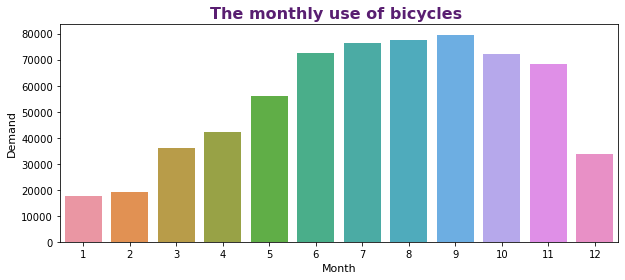

In [37]:
fig, ax = pp.subplots(figsize=(10,4))

sns.barplot(x=monthly_demand.index.get_level_values(0), y=monthly_demand["trip_id"],ax=ax)
pp.xlabel("Month", fontsize=11)
pp.ylabel("Demand", fontsize=11)
sns.set_color_codes("dark")
pp.title("The monthly use of bicycles ", fontsize=16, fontweight="bold", color="m")
pp.show()

## b) Geographical Demand Patterns (Nico)

In [38]:
#popular start station
start_stations = df.groupby(["start_station_id"])["start_lat","start_lon"].mean()
start_stations = pd.DataFrame(start_stations)

start_stations

,start_lat,start_lon
start_station_id,,
3000,0.000000,0.000000
3004,39.953781,-75.163741
3005,39.947330,-75.144029
3006,39.952201,-75.203110
3007,39.945171,-75.159928
...,...,...
3122,39.980621,-75.173500
3123,39.980042,-75.170882
3124,39.952950,-75.139792


In [39]:
start_df = df.groupby(["start_station_id"])["trip_id"].nunique()
start_df = pd.DataFrame(start_df)
start_df

,trip_id
start_station_id,
3000,2
3004,9679
3005,4275
3006,8314
3007,12387
...,...
3122,667
3123,1028
3124,3751


In [40]:
start_stations_sample = start_stations.join(start_df)
start_stations_sample

,start_lat,start_lon,trip_id
start_station_id,,,
3000,0.000000,0.000000,2
3004,39.953781,-75.163741,9679
3005,39.947330,-75.144029,4275
3006,39.952201,-75.203110,8314
3007,39.945171,-75.159928,12387
...,...,...,...
3122,39.980621,-75.173500,667
3123,39.980042,-75.170882,1028
3124,39.952950,-75.139792,3751


In [41]:
start_stations_sample.drop([3000], inplace=True)

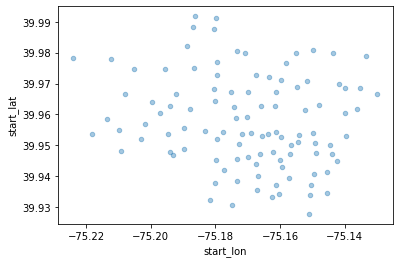

In [135]:
start_stations_sample.plot(kind="scatter", x="start_lon", y="start_lat", alpha=0.4)
pp.show()

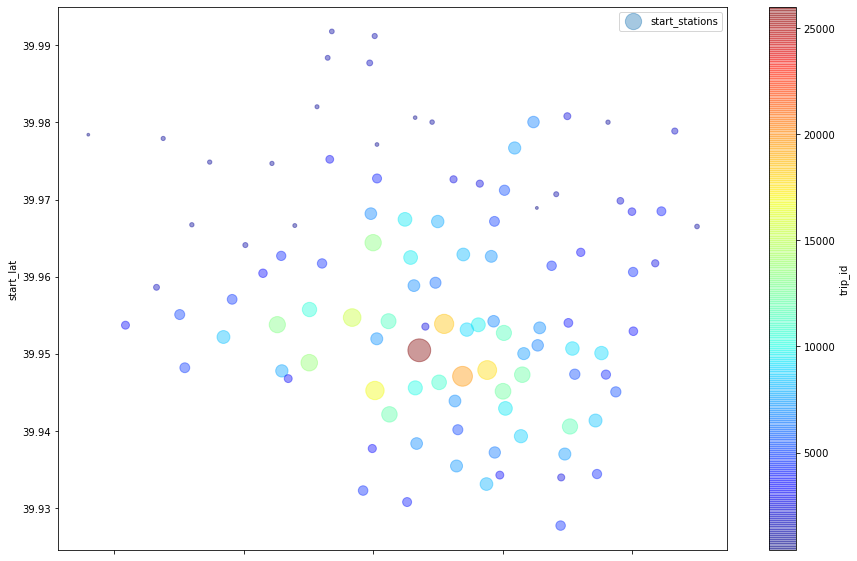

In [161]:
start_stations_sample.plot(kind="scatter", x="start_lon", y="start_lat",
                          s=start_stations_sample["trip_id"]/50, label="start_stations", c="trip_id",
                          cmap=pp.get_cmap("jet"), colorbar=True, alpha=0.4, figsize=(15,10))
pp.legend()
pp.show()

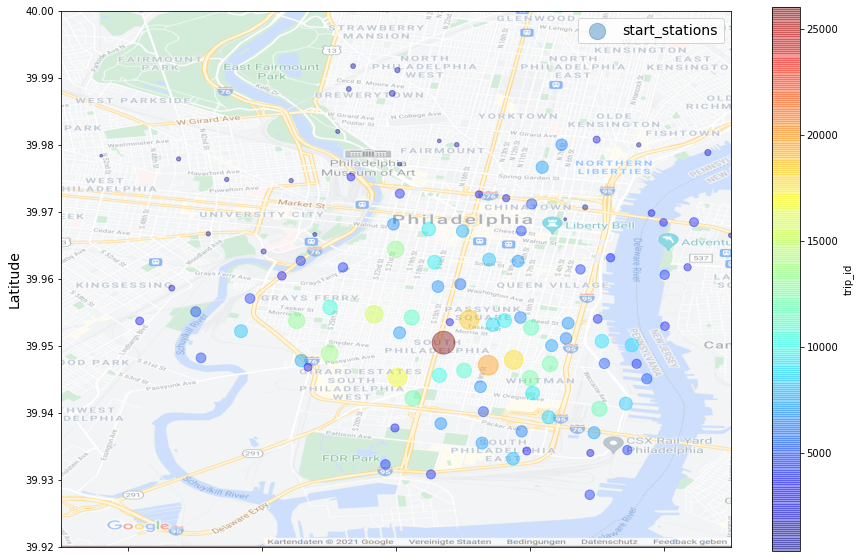

In [162]:
philadelphia_map=img.imread("Datasets/Map_Philadelphia_20210713.png")
ax = start_stations_sample.plot(kind="scatter", x="start_lon", y="start_lat",
                          s=start_stations_sample["trip_id"]/50, label="start_stations", c="trip_id",
                          cmap=pp.get_cmap("jet"), colorbar=True, alpha=0.4, figsize=(15,10))
pp.imshow(philadelphia_map, extent=[-75.23,-75.13,39.92,40], alpha=0.5)
pp.ylabel("Latitude", fontsize=14)
pp.xlabel("Longitude", fontsize=14)

pp.legend(fontsize=14)
pp.show()

In [43]:
#popular end station
end_stations = df.groupby(["end_station_id"])["trip_id"].nunique()
end_stations = pd.DataFrame(end_stations)
end_stations

,trip_id
end_station_id,
3000,1732
3004,10465
3005,4812
3006,7420
3007,12939
...,...
3122,651
3123,878
3124,4123


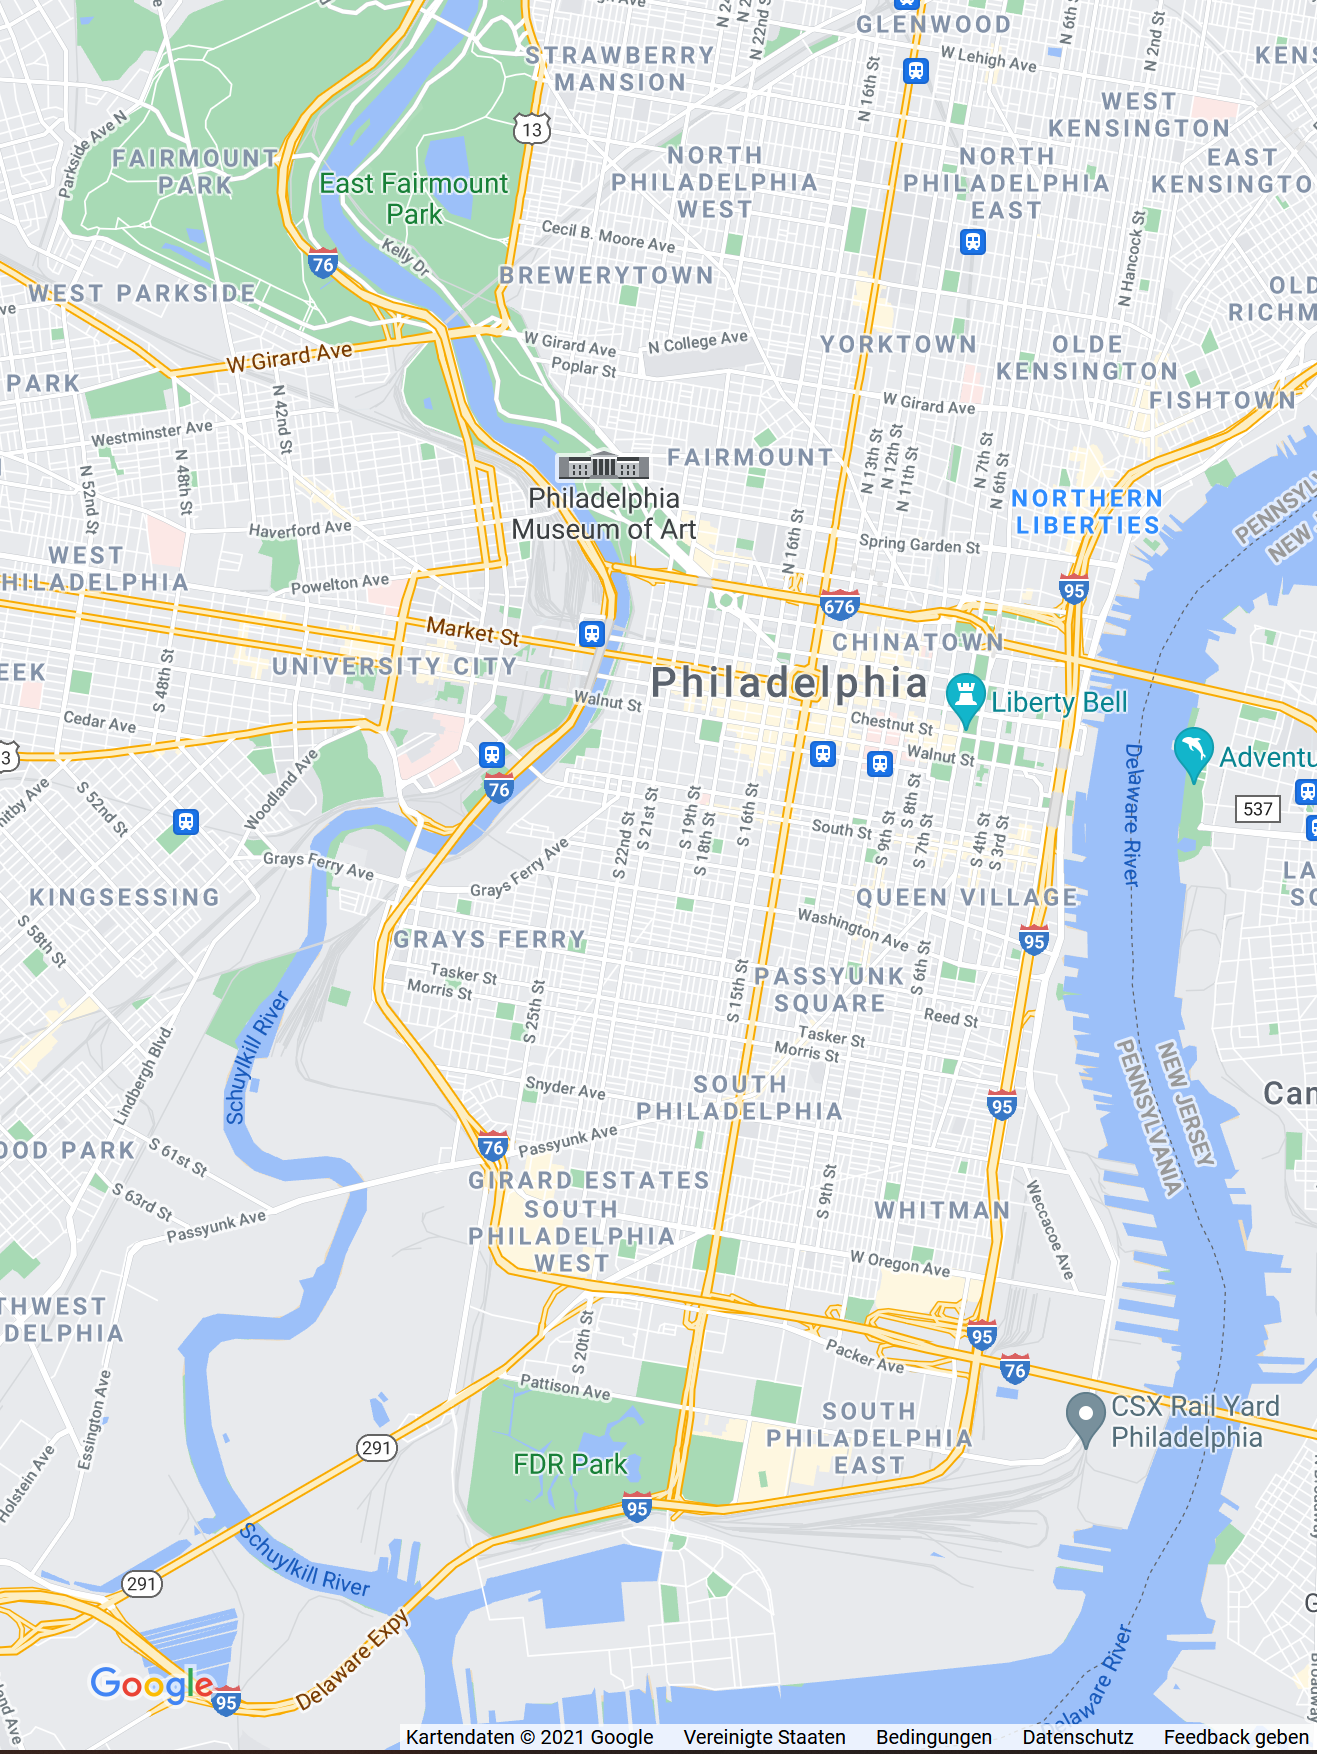

In [44]:
display.Image("Datasets/Map_Philadelphia_20210713.png")

In [45]:
start_stations.columns = ['start_station_id','']

### c) KPIs

Our first KPI is the current gross revenue which is calculated by the duration of the trip times $0,15 which is listed as the price/minute on Indego's website. We have to make some adjustments based depending on the type of pass the user has. For that we create a new dataframe only containing relevant data for us which includes the duration of the trip, the ID, the passtype, as well as some time info.

In [46]:
price_per_minute = 0.15

In [47]:
rev = df[['trip_id', 'duration', 'start_time', 'end_time', 'passholder_type', 'hour','date_hour']].copy()

In [48]:
rev.head()

,trip_id,duration,start_time,end_time,passholder_type,hour,date_hour
0,4516691,10.0,2016-01-01 00:04:00,2016-01-01 00:14:00,Indego30,0,01-01-00
1,4516692,22.0,2016-01-01 00:07:00,2016-01-01 00:29:00,Indego30,0,01-01-00
2,4516693,13.0,2016-01-01 00:14:00,2016-01-01 00:27:00,Indego30,0,01-01-00
3,4516694,22.0,2016-01-01 00:20:00,2016-01-01 00:42:00,Walk-up,0,01-01-00
4,4516695,10.0,2016-01-01 00:20:00,2016-01-01 00:30:00,Indego30,0,01-01-00


Since we take the price per minute and the duration of the trip is in seconds, we are going to divide the duration by 60 to get it in minutes.

In [49]:
#rev["duration"] = rev["duration"]/60

In [50]:
a = rev['passholder_type'].unique()
a

array(['Indego30', 'Walk-up', 'IndegoFlex'], dtype=object)

In [51]:
rev['relevant_duration'] = rev.duration + rev.passholder_type.map( lambda x: -30 if x == 'Walk-up' else -60)

In [52]:
rev.head()

,trip_id,duration,start_time,end_time,passholder_type,hour,date_hour,relevant_duration
0,4516691,10.0,2016-01-01 00:04:00,2016-01-01 00:14:00,Indego30,0,01-01-00,-50.0
1,4516692,22.0,2016-01-01 00:07:00,2016-01-01 00:29:00,Indego30,0,01-01-00,-38.0
2,4516693,13.0,2016-01-01 00:14:00,2016-01-01 00:27:00,Indego30,0,01-01-00,-47.0
3,4516694,22.0,2016-01-01 00:20:00,2016-01-01 00:42:00,Walk-up,0,01-01-00,-8.0
4,4516695,10.0,2016-01-01 00:20:00,2016-01-01 00:30:00,Indego30,0,01-01-00,-50.0


In [53]:
rev.loc[rev.relevant_duration <= 0, "relevant_duration"] = 0

In [54]:
rev["rev_flex"] = rev["relevant_duration"] * price_per_minute

In [55]:
rev.head()

,trip_id,duration,start_time,end_time,passholder_type,hour,date_hour,relevant_duration,rev_flex
0,4516691,10.0,2016-01-01 00:04:00,2016-01-01 00:14:00,Indego30,0,01-01-00,0.0,0.0
1,4516692,22.0,2016-01-01 00:07:00,2016-01-01 00:29:00,Indego30,0,01-01-00,0.0,0.0
2,4516693,13.0,2016-01-01 00:14:00,2016-01-01 00:27:00,Indego30,0,01-01-00,0.0,0.0
3,4516694,22.0,2016-01-01 00:20:00,2016-01-01 00:42:00,Walk-up,0,01-01-00,0.0,0.0
4,4516695,10.0,2016-01-01 00:20:00,2016-01-01 00:30:00,Indego30,0,01-01-00,0.0,0.0


In [56]:
sum(rev["rev_flex"])

624540.7500000183

In [57]:
hourly_rev = rev.groupby(["date_hour"]).agg(revenue=("rev_flex", 'sum'))
hourly_rev = pd.DataFrame(hourly_rev)
hourly_rev

,revenue
date_hour,
01-01-00,81.15
01-01-01,360.45
01-01-02,271.35
01-01-03,40.35
01-01-04,0.00
...,...
12-31-19,3.75
12-31-20,0.00
12-31-21,87.75


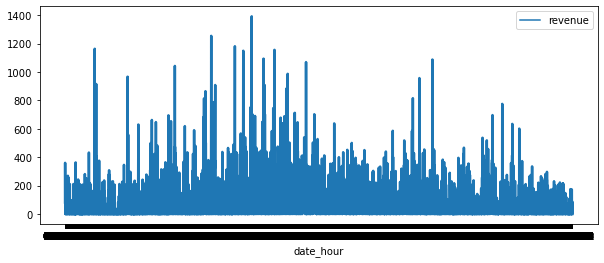

In [58]:
fig, ax = pp.subplots(figsize=(10,4))

sns.lineplot(data=hourly_rev, palette="tab10", linewidth=2.5)
pp.show()

Another KPI could be the share of walkups vs. passcard holder.

In [59]:
type_shares = df[['passholder_type', 'date_hour']].copy()

In [60]:
type_shares['type'] = type_shares.passholder_type.map( lambda x: 0 if x == 'Walk-up' else 1)

In [61]:
type_shares.head()

,passholder_type,date_hour,type
0,Indego30,01-01-00,1
1,Indego30,01-01-00,1
2,Indego30,01-01-00,1
3,Walk-up,01-01-00,0
4,Indego30,01-01-00,1


In [62]:
hourly_share = type_shares.groupby(["date_hour", "type"]).count()
hourly_share = pd.DataFrame(hourly_share)
hourly_share

passholder_type
date_hour type                 
01-01-00  0                  11
          1                  15
01-01-01  0                  28
          1                  12
01-01-02  0                  21
...                         ...
12-31-21  0                   1
          1                  17
12-31-22  0                  13
          1                   8
12-31-23  1                  12

[15894 rows x 1 columns]

In [63]:
hourly_share_per = hourly_share.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [64]:
hourly_share_per

passholder_type
date_hour type                 
01-01-00  0           42.307692
          1           57.692308
01-01-01  0           70.000000
          1           30.000000
01-01-02  0           63.636364
...                         ...
12-31-21  0            5.555556
          1           94.444444
12-31-22  0           61.904762
          1           38.095238
12-31-23  1          100.000000

[15894 rows x 1 columns]

#  Task 3: Predictive Analytics

## Philadelphia weather in 2016

In [65]:
#calculate the weather over the year:
# different approach:
weather_month = df_weather.groupby(["month"]).agg(Temperature =("max_temp", 'mean'))
weather_month = pd.DataFrame(weather_month)
weather_month


,Temperature
month,
1,1.871327
2,5.013163
3,12.008359
4,13.794522
5,18.359349
6,23.889473
7,27.489751
8,27.237493
9,23.435936


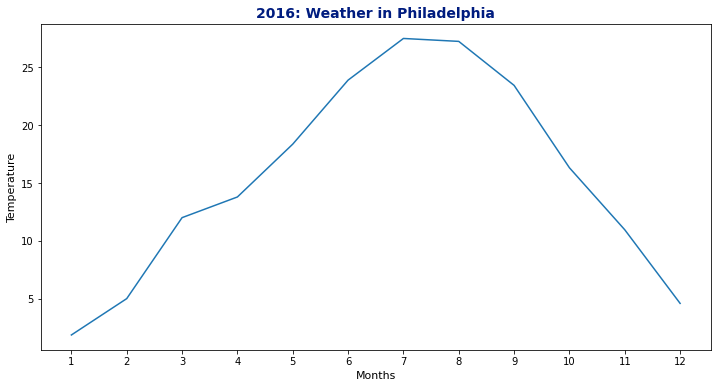

In [66]:
fig, ax = pp.subplots(figsize=(12,6))

sns.lineplot(x=weather_month.index.get_level_values(0), y=weather_month["Temperature"],ax=ax)
dim=np.arange(1,13,1)
pp.xticks(dim)
pp.xlabel("Months", fontsize=11)
pp.ylabel("Temperature", fontsize=11)
pp.title("2016: Weather in Philadelphia", fontsize=14, fontweight="bold", color="b")
pp.show()

### Demand and temperatures in comparison 

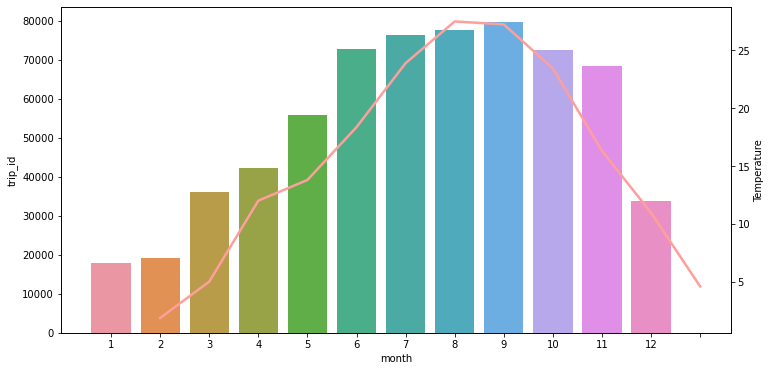

In [67]:
fig, ax = pp.subplots(figsize=(12,6))

sns.barplot(x=monthly_demand.index.get_level_values(0), y=monthly_demand["trip_id"],ax=ax)
sns.set_color_codes("pastel")
ax2=ax.twinx()
sns.lineplot(x=weather_month.index.get_level_values(0), y=weather_month["Temperature"],ax=ax2, color="r", linewidth=2.5)
dim=np.arange(0,13,1)
pp.xticks(dim)

pp.show()

Future demand is a key factor that will steer operational decision making of a shared rental network. As a data scientist it is your responsibility to facilitate this type of decision support. For the purpose of this assignment we will be interested in forecasting total system-level demand in the next hour. To do so, develop a prediction model that predicts bike rental demand as a function of suitable features available in or derived from the datasets (incl. the weather data).

First of all, i am going to create a table that contains the demand of the hour along with some features as temperature, the hour of course, the day of the week and the time of the year.

In [68]:
#new_df = df[["trip_id","weekday", "month"]].groupby(["weekday"])'

new_df_merged = pd.merge(weather, hourly_demand, on=["date", "hour"], how = "left")
new_df_merged["demand"] = new_df_merged["trip_id"]
new_df_merged["weekday"] = new_df_merged["date_time"].apply(lambda dt: dt.dayofweek)
new_df_merged["month"] = new_df_merged["date_time"].apply(lambda dt: dt.month)
new_df_merged

,date_time,max_temp,min_temp,precip,date,hour,date_hour,year,trip_id,demand,weekday,month
0,2016-01-01 01:00:00,7.2,7.2,0.0,01-01,1.0,01-01-01,2016.0,40.0,40.0,4,1
1,2016-01-01 02:00:00,6.7,6.7,0.0,01-01,2.0,01-01-02,2016.0,33.0,33.0,4,1
2,2016-01-01 03:00:00,6.7,6.7,0.0,01-01,3.0,01-01-03,2016.0,6.0,6.0,4,1
3,2016-01-01 04:00:00,6.1,6.1,0.0,01-01,4.0,01-01-04,2016.0,1.0,1.0,4,1
4,2016-01-01 05:00:00,6.1,6.1,0.0,01-01,5.0,01-01-05,2016.0,4.0,4.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8775,2016-12-31 19:00:00,6.1,6.1,0.0,12-31,19.0,12-31-19,2016.0,28.0,28.0,5,12
8776,2016-12-31 20:00:00,6.7,6.7,0.0,12-31,20.0,12-31-20,2016.0,29.0,29.0,5,12
8777,2016-12-31 21:00:00,6.7,6.7,0.0,12-31,21.0,12-31-21,2016.0,18.0,18.0,5,12
8778,2016-12-31 22:00:00,6.7,6.7,0.0,12-31,22.0,12-31-22,2016.0,21.0,21.0,5,12


In [69]:
new_df_merged.drop(columns = ['trip_id'])

,date_time,max_temp,min_temp,precip,date,hour,date_hour,year,demand,weekday,month
0,2016-01-01 01:00:00,7.2,7.2,0.0,01-01,1.0,01-01-01,2016.0,40.0,4,1
1,2016-01-01 02:00:00,6.7,6.7,0.0,01-01,2.0,01-01-02,2016.0,33.0,4,1
2,2016-01-01 03:00:00,6.7,6.7,0.0,01-01,3.0,01-01-03,2016.0,6.0,4,1
3,2016-01-01 04:00:00,6.1,6.1,0.0,01-01,4.0,01-01-04,2016.0,1.0,4,1
4,2016-01-01 05:00:00,6.1,6.1,0.0,01-01,5.0,01-01-05,2016.0,4.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
8775,2016-12-31 19:00:00,6.1,6.1,0.0,12-31,19.0,12-31-19,2016.0,28.0,5,12
8776,2016-12-31 20:00:00,6.7,6.7,0.0,12-31,20.0,12-31-20,2016.0,29.0,5,12
8777,2016-12-31 21:00:00,6.7,6.7,0.0,12-31,21.0,12-31-21,2016.0,18.0,5,12
8778,2016-12-31 22:00:00,6.7,6.7,0.0,12-31,22.0,12-31-22,2016.0,21.0,5,12


Here i check whether holidays like the 4th of July are having an impact on demand.

In [70]:
july = new_df_merged[new_df_merged['month'] == 7]
july

,date_time,max_temp,min_temp,precip,date,hour,date_hour,year,trip_id,demand,weekday,month
4346,2016-07-01 01:00:00,25.6,25.6,0.0,07-01,1.0,07-01-01,2016.0,20.0,20.0,4,7
4347,2016-07-01 02:00:00,25.0,25.0,0.0,07-01,2.0,07-01-02,2016.0,10.0,10.0,4,7
4348,2016-07-01 03:00:00,23.9,23.9,0.0,07-01,3.0,07-01-03,2016.0,2.0,2.0,4,7
4349,2016-07-01 04:00:00,23.3,23.3,0.0,07-01,4.0,07-01-04,2016.0,9.0,9.0,4,7
4369,2016-07-01 00:00:00,27.2,27.2,0.0,07-01,0.0,07-01-00,2016.0,28.0,28.0,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...
5108,2016-07-31 19:00:00,31.1,31.1,0.0,07-31,19.0,07-31-19,2016.0,121.0,121.0,6,7
5109,2016-07-31 20:00:00,31.7,31.7,0.0,07-31,20.0,07-31-20,2016.0,103.0,103.0,6,7
5110,2016-07-31 21:00:00,32.2,32.2,0.0,07-31,21.0,07-31-21,2016.0,93.0,93.0,6,7
5111,2016-07-31 22:00:00,31.7,31.7,0.0,07-31,22.0,07-31-22,2016.0,64.0,64.0,6,7


In [71]:
july_grouped = july.groupby(["date"])["demand"].sum()
july_grouped = pd.DataFrame(july_grouped)
july_grouped
#monthly_demand = df.groupby(["month"])["trip_id"].nunique()

#monthly_demand = pd.DataFrame(monthly_demand)
#monthly_demand

,demand
date,
07-01,2408.0
07-02,2576.0
07-03,2398.0
07-04,2270.0
07-05,2355.0
07-06,2592.0
07-07,2452.0
07-08,2417.0
07-09,1954.0


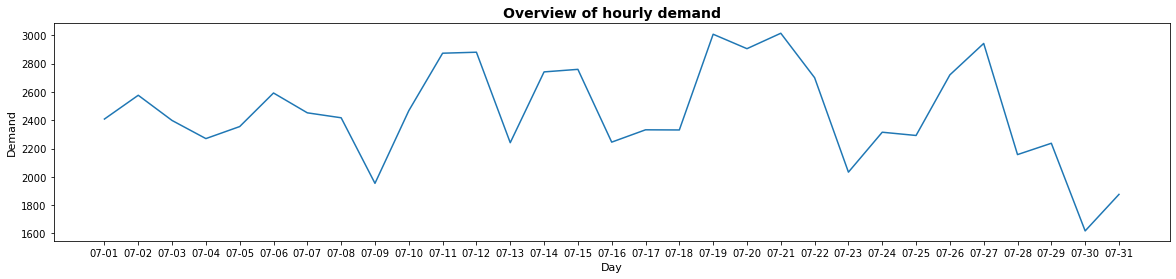

In [72]:
fig, ax = pp.subplots(figsize=(20,4))

sns.lineplot(x=july_grouped.index.get_level_values(0), y=july_grouped["demand"],ax=ax)
pp.xlabel('Day', fontdict={'size':11})
pp.ylabel("Demand", fontdict={"size":11})
pp.title("Overview of hourly demand", fontsize=14.0, fontweight='bold')

pp.show()

In [73]:
xp = new_df_merged['max_temp']
yp = new_df_merged['demand']
xp

0       7.2
1       6.7
2       6.7
3       6.1
4       6.1
       ... 
8775    6.1
8776    6.7
8777    6.7
8778    6.7
8779    6.1
Name: max_temp, Length: 8780, dtype: float64

In [74]:
new_df_merged.fillna(0)

,date_time,max_temp,min_temp,precip,date,hour,date_hour,year,trip_id,demand,weekday,month
0,2016-01-01 01:00:00,7.2,7.2,0.0,01-01,1.0,01-01-01,2016.0,40.0,40.0,4,1
1,2016-01-01 02:00:00,6.7,6.7,0.0,01-01,2.0,01-01-02,2016.0,33.0,33.0,4,1
2,2016-01-01 03:00:00,6.7,6.7,0.0,01-01,3.0,01-01-03,2016.0,6.0,6.0,4,1
3,2016-01-01 04:00:00,6.1,6.1,0.0,01-01,4.0,01-01-04,2016.0,1.0,1.0,4,1
4,2016-01-01 05:00:00,6.1,6.1,0.0,01-01,5.0,01-01-05,2016.0,4.0,4.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8775,2016-12-31 19:00:00,6.1,6.1,0.0,12-31,19.0,12-31-19,2016.0,28.0,28.0,5,12
8776,2016-12-31 20:00:00,6.7,6.7,0.0,12-31,20.0,12-31-20,2016.0,29.0,29.0,5,12
8777,2016-12-31 21:00:00,6.7,6.7,0.0,12-31,21.0,12-31-21,2016.0,18.0,18.0,5,12
8778,2016-12-31 22:00:00,6.7,6.7,0.0,12-31,22.0,12-31-22,2016.0,21.0,21.0,5,12


In [75]:
#We fill hours that did not have any demand with an demand of 0.
#They did not appear in the data frame as there were no trip.
new_df_merged["demand"].fillna(0, inplace=True)
new_df_merged["trip_id"].fillna(0, inplace=True)

In [76]:
new_df_merged.isnull().sum()

date_time    0
max_temp     0
min_temp     0
precip       0
date         0
hour         0
date_hour    0
year         0
trip_id      0
demand       0
weekday      0
month        0
dtype: int64

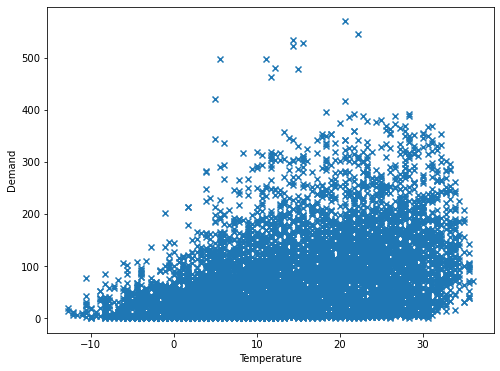

In [77]:
fig, ax = pp.subplots(figsize = (8,6))
# Plotting the data
ax.scatter(xp, yp, marker='x',)
ax.set_xlabel("Temperature")
ax.set_ylabel("Demand")

pp.show()

We have to normalize the data to make it work properly:

In [78]:
x_nor = (xp-min(xp))/(max(xp)-min(xp))

y_nor = (yp-min(yp))/(max(yp)-min(yp))


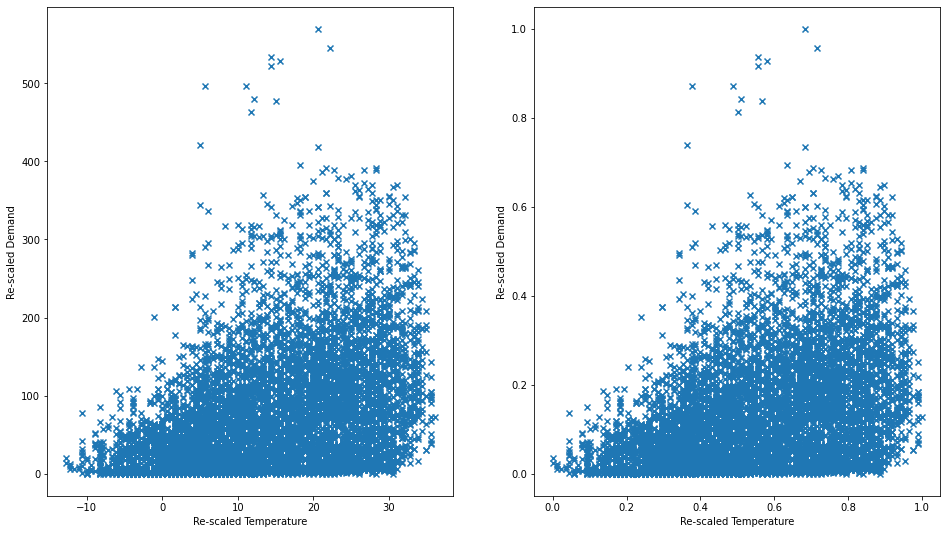

In [79]:
fig, axes = pp.subplots(1,2,figsize = (16,9))

axes[0].scatter(xp, yp, marker='x')
axes[0].set_xlabel("Re-scaled Temperature")
axes[0].set_ylabel("Re-scaled Demand")

axes[1].scatter(x_nor, y_nor, marker = 'x')
axes[1].set_xlabel("Re-scaled Temperature")
axes[1].set_ylabel("Re-scaled Demand")

pp.show()

In [80]:
X = new_df_merged["max_temp"].values.reshape((-1,1))
y = new_df_merged["demand"]
#y = np.squeeze(y)

X

array([[7.2],
       [6.7],
       [6.7],
       ...,
       [6.7],
       [6.7],
       [6.1]])

In [81]:
lm = LinearRegression(fit_intercept=True, normalize=False)

In [82]:
y.ndim

1

In [83]:
np.any(np.isnan(y))

False

In [84]:
np.isnan(X.any())
np.isfinite(X.all())

True

In [85]:
np.any(np.isnan(X))

False

In [86]:
X = X[np.logical_not(np.isnan(X))]
X = X.reshape((-1,1))

In [87]:
X.ndim

2

In [88]:
lm.fit(X, y)
print(lm.coef_, lm.intercept_)

[2.82421668] 32.64876156124159


In [89]:
Xnew = np.array([[-10]])
print(lm.predict(Xnew))

[4.40659472]


In [90]:
lr = LinearRegression()
lr.fit(xp.values.reshape(-1,1), yp)
model_pred = lm.predict(xp.values.reshape(-1,1))

[2.82421668] 32.64876156124159


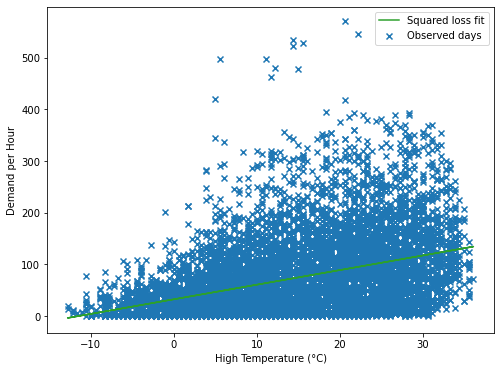

In [91]:
fig,ax = pp.subplots(figsize = (8,6))

ax.scatter(xp, yp, marker="x")
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Demand per Hour")

ax.plot(xp, model_pred, c='C2')
ax.legend(['Squared loss fit','Observed days'])
#plt.savefig('summer data_peak demand_line.pdf')
print(lr.coef_, lr.intercept_)

#### Regression Model Evaluation

In [92]:
y_true = new_df_merged["demand"]
y_pred = lm.predict(new_df_merged["max_temp"].values.reshape((-1,1)))

In [93]:
#Calculate MSE and RMSE to calculate how much the prediction differs from the actual data
print("Mean Squared Error:",mean_squared_error(y_pred, y_true),"(demand)^2")
print("Root Mean Squared Error:",mean_squared_error(y_pred, y_true)**0.5,"demand")

Mean Squared Error: 4697.051516847088 (demand)^2
Root Mean Squared Error: 68.53503860688406 demand


In [94]:
#Calculate the MAE which tells the mean aboslute value of the error term
print("Mean Absolute Error:",mean_absolute_error(y_pred, y_true),"demand")

Mean Absolute Error: 51.493653726012546 demand


In [95]:
#Caculate the Coefficient of determination, has to be between 0 and 1 so sth is wrong here
print("Coefficient of determination:",r2_score(y_pred, y_true))

Coefficient of determination: -4.779451085809281


#### Workshop 08

In [96]:
#Now we are going to take a closer look at demand during the warmer months as they indicate a higher demand
df_summer = new_df_merged[(new_df_merged["month"]>5)& (new_df_merged["month"]<12)]

In [97]:
X = df_summer["max_temp"].values.reshape((-1,1)) # if we pass a 1-feature array we need to re-shape it!
y = df_summer["demand"]

[1.32248623] 73.71364439287696


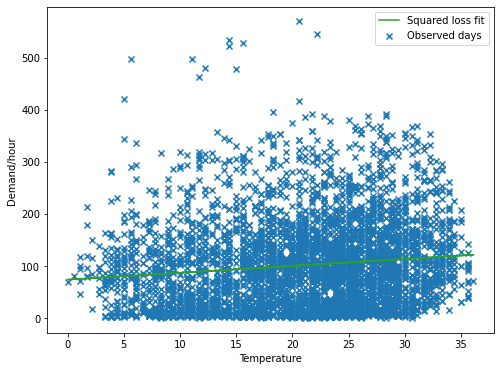

In [98]:
# initialize model
lin_mod = LinearRegression()

#train model
lin_mod.fit(X, y)

#make predictions using model
model_pred = lin_mod.predict(X)

# plot resulzts
pp.figure(figsize = (8,6))
pp.scatter(X, y, marker="x")
pp.xlabel("Temperature")
pp.ylabel("Demand/hour")
pp.plot(X, model_pred, c='C2')
pp.legend(['Squared loss fit','Observed days'])
print(lin_mod.coef_, lin_mod.intercept_)

## Multi-dimensional linear regression 

In [99]:
#We include Weekday as a feature since we assume that it indicates higher demand.
#For that we create an extra column which says whether a day is a weekday or not.
df_summer["IsWeekday"] = df_summer["weekday"].apply(lambda x: 1 if x<=4 else 0)

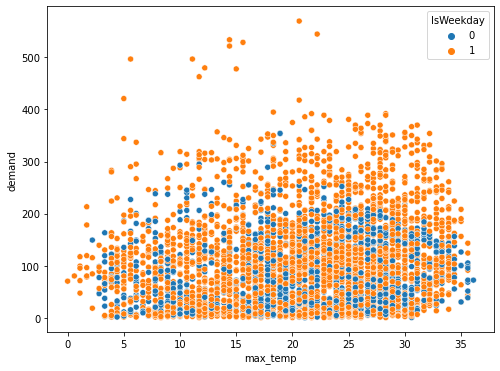

In [100]:
pp.figure(figsize = (8,6))

sns.scatterplot(x=df_summer["max_temp"], y=df_summer["demand"], 
                hue=df_summer["IsWeekday"])
pp.show()

In [101]:
#Let us train a new linear model that takes in a additional feature.
X = df_summer[["max_temp", "IsWeekday"]]
y = df_summer[["demand"]]
lin_mod_day = LinearRegression()
lin_mod_day.fit(X,y)
print(lin_mod_day.coef_, lin_mod_day.intercept_)

[[ 1.32247327 21.39489361]] [58.40818965]


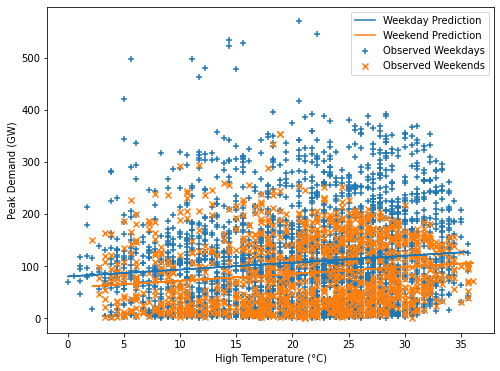

In [102]:
X_weekday = X[X["IsWeekday"]==1]
X_weekend = X[X["IsWeekday"]==0]

# predict weekends and weekdays seperately
y_pred_weekday = lin_mod_day.predict(X_weekday)
y_pred_weekend = lin_mod_day.predict(X_weekend)

pp.figure(figsize = (8,6))

pp.scatter(X_weekday["max_temp"], 
            df_summer[df_summer["IsWeekday"]==True]["demand"], 
            marker="+", label="Observed Weekdays")

pp.scatter(X_weekend["max_temp"], 
            df_summer[df_summer["IsWeekday"]==False]["demand"], 
            marker="x", label="Observed Weekends")

pp.plot(X_weekday["max_temp"], 
         y_pred_weekday, 
         label="Weekday Prediction")
pp.plot(X_weekend["max_temp"], 
         y_pred_weekend, 
         label="Weekend Prediction")

pp.xlabel("High Temperature (°C)")
pp.ylabel("Peak Demand (GW)")

pp.legend()
pp.show()

#### Non-linear modelling (polynominal regression)

In [103]:
xp = new_df_merged["max_temp"].values
yp = new_df_merged["demand"].values

In [104]:
def plot_regression_poly_scikit(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    pp.figure(figsize = (8,6))
    pp.scatter(X,Y,marker="x", c='C2')
    ylim = pp.ylim()
    pp.plot(x_fit,y_pred, c='C1')
    pp.xlabel("Temperature (°C)")
    pp.ylabel("Demand (GW)")
    pp.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    pp.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.1480924570833222


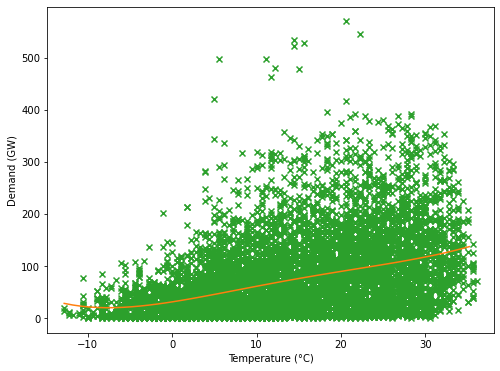

In [105]:
plot_regression_poly_scikit(X = xp, Y = yp, d = 5)

In [106]:
#Now the set is going to be splitted
x_train, x_test, y_train, y_test = train_test_split(new_df_merged["max_temp"], new_df_merged["demand"], test_size=0.3,random_state=42)
X_train, X_hold, y_train, y_hold = train_test_split(x_train, y_train, test_size=(0.2/0.7),random_state=34 )

ValueError: x and y must be the same size

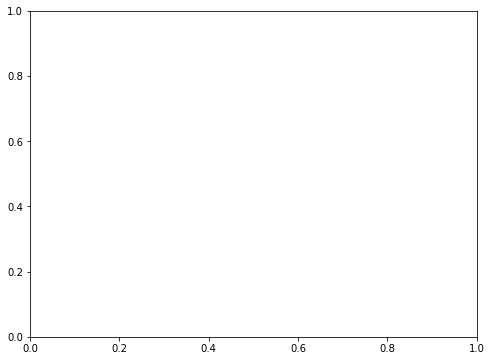

In [107]:
pp.figure(figsize = (8,6))
pp.scatter(x_train, y_train, marker='x', color="C0")
pp.scatter(x_test, y_test, marker='x', color="C2")
pp.xlabel("Temperature (°C)")
pp.ylabel("Demand (GW)")
pp.legend(['Training set', 'Holdout set'])
pp.show()

In [ ]:
len(x_train)

In [ ]:
len(x_test)